# Private Support Points: Regression Examples

___

In [1]:
import json
import logging
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import os
import pdb
import sklearn
from sklearn.datasets import load_boston, load_diabetes, fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
import time

from sp_utils import (
    scale_01,
    get_energy_sensitivity,
    get_support_points,
    energy,
    sample_sp_exp_mech,
    sample_sp_mmd_dp_bw,
    mixture_model_likelihood,
    sample_full_set_given_bandwidth)

plt.style.use('ggplot')
#font = {'family' : 'normal',
#        'size'   : 14}
#matplotlib.rc('font', **font)

In [2]:
# Set up logging.
log_filename = '../output/regression_logs/run.log'
if os.path.isfile(log_filename):
    os.remove(log_filename)
logging.basicConfig(filename=log_filename,
                             filemode='a',
                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                             datefmt='%H:%M:%S',
                             level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING)
_LOG = logging.getLogger('[perturbed]')

# Support points accurately model toy multivariate data in 5D.

In [3]:
def plot_nd(d, w=10, h=10, title=None):
    graph = pd.plotting.scatter_matrix(pd.DataFrame(d), figsize=(w, h));
    if title:
        plt.suptitle(title)
    plt.show()

In [4]:
# Test support points on multivariate Gaussian data.
if 0:
    num_data = 500
    DIM = 5
    data = np.random.normal(0, 1, size=(num_data, DIM))
    num_supp = 100
    MAX_ITER = 501 #300
    LR = 5e-1 #1e1

    y_opt, e_opt = get_support_points(data, num_supp, MAX_ITER, LR, is_tf=True,
                                      Y_INIT_OPTION='uniform', clip='data')

    plot_nd(pd.DataFrame(data), 5, 5, 'data')
    plot_nd(pd.DataFrame(y_opt), 5, 5, 'sp')

# Test variance of Support Point Optimization vs variance of Metropolis Hastings Sampling.

In [5]:
num_data = 500
num_supp = 50
DIM = 2
MAX_ITER = 201
LR = 5e-1
ENERGY_POWER = 2
ALPHA = 10


num_sp_samples = 3

# Make data.
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]
data = np.random.multivariate_normal(mean, cov, [num_data])
data = scale_01(data)
energy_sensitivity = get_energy_sensitivity(data, num_supp)


if 0:

    # ------------------------------------------------------------------
    # Given data, repeated support point optimizations are low variance.
    # ------------------------------------------------------------------

    plt.scatter(data[:, 0], data[:, 1], c='gray', s=64,
                alpha=0.3, label='data')
    for i in range(num_sp_samples):
        y_opt, e_opt = get_support_points(data, num_supp, MAX_ITER, LR, is_tf=True,
                                          Y_INIT_OPTION='uniform', clip='data',
                                          plot=False)
        plt.scatter(y_opt[:, 0], y_opt[:, 1], s=32, label='sp_{}'.format(i))

    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()


    # ---------------------------------------------------------------
    # Given support points, repeated diffusions create more variance.
    # ---------------------------------------------------------------

    # Get private support points.
    y_opt, e_opt = get_support_points(data, num_supp, MAX_ITER, LR, is_tf=True,
                                      Y_INIT_OPTION='uniform', clip='data',
                                      plot=False)
    (y_tildes,
     energies,
     energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity, data, y_opt, 'mh',
                                         num_y_tildes=num_sp_samples,
                                         alpha=ALPHA,
                                         diffusion_mean=True,
                                         save_dir='../output/regression_logs')

    plt.scatter(data[:, 0], data[:, 1], c='gray', s=64,
                alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], s=32, c='limegreen',
                label='sp')
    for i in range(num_sp_samples):
        y_priv = y_tildes[i]
        plt.scatter(y_priv[:, 0], y_priv[:, 1], s=32, label='~sp_{}'.format(i))
    plt.title(('|data|={}, |supp|={}, eps={:.3f}, e_opt: {:.8f}').format(
                   num_data, num_supp, ALPHA, e_opt))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

___

# Regression task.

In [6]:
def test_regression(data, data_heldout):
    """Computes regression accuracy, averaged over multiple runs.
    
    Each run computes accuracy with k-fold cross validation.
    
    Args:
      data (array): Training data.
      data_heldout (array): Testing/heldout data.
    
    Returns:
      result (scalar): MSE value on test data.
    """
    
    def regress(X_train, X_test, Y_train, Y_test):
        # Fits linear model given a train-test split.
        # Returns MSE value of fitted model.
        lm = LinearRegression()
        lm.fit(X_train, Y_train)

        Y_pred = lm.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        r2 = lm.score(X_test, Y_test)
        
        return mse
    
        
    result = regress(data[:, :-1], data_heldout[:, :-1],
                     data[:, -1], data_heldout[:, -1])
    
    return result

## Helper functions for running experiments.

In [7]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset_name size alpha mse std tag')


def visualize_data(data, title=None):
    # Visualize data with pairs plot.
    if len(data) >= 1000:
        _d = data[np.random.choice(len(data), 500)]             
        plot_nd(_d, 10, 10, title)
    else:
        plot_nd(data, 10, 10, title)


def round_binary_cols(data, binary_cols):
    """Rounds binary cols of a NumPy array."""
    for col in binary_cols:
        col_data = data[:, col]
        col_data = np.clip(col_data, 0, 1)
        col_data = np.round(col_data)
        data[:, col] = col_data
    return data


def get_accuracy_mean_std_on_heldout(candidate_sets, heldout, data,
                                     dataset_name, num_supp, alpha=None, tag=None):
    """Computes regression accuracy results for a multiset of candidate points.
    
    Multiset can be random subsets of data, can be sets of support points, or
    can be sets of privatized support points.

    Args:
        candidate_sets (array): Multiset of candidate points.
        heldout (array): Array of test data.
        data (array): Data for plotting.
        dataset_name (string): Name of data set.
        num_supp (int): Number of support points.
        alpha (float): Privacy budget.
        tag (string): Tag for Result object.

    Returns:
        result_priv (Result): Named tuple of result for private support points.
    """
    # Collect accuracy values for each sample.
    accuracies = []
    for candidate_set in candidate_sets:
        accuracy = test_regression(candidate_set, heldout)
        accuracies.append(accuracy)
    _LOG.info('accuracies_min_max = {}, {}'.format(min(accuracies),
                                                   max(accuracies)))
    _LOG.info('accuracies_std = {}'.format(np.std(accuracies)))

    # Mean, Std of accuracies across samples.
    accuracy_mean = np.round(np.mean(accuracies), 4)
    accuracy_std = np.round(np.std(accuracies), 4)

    # Store results of sample runs for this (num_supp, alpha) combination.
    result = Result(dataset_name, num_supp, alpha, accuracy_mean, accuracy_std, tag)

    # Visualize data versus sample of private support points.
    #visualize_data(data, 'data')
    #visualize_data(candidate_sets[-1], 'num_supp={}, alpha={}'.format(num_supp, alpha))

    return result
                

def resample_from_histdd(H, edge_sets, n=100, plot=False):
    """Resamples data set from histogram, uniformly over bins.
    
    Args:
        H (array): Arrays of counts per bin.
        edge_sets (array): Arrays of edge boundaries per dim.
        n (int): Number of points to sample.

    Returns:
        resampled (array): Newly sampled data.
    """
    bin_widths = [np.diff(edges)[0] for edges in edge_sets]
    midpoints = [edges[:-1] + np.diff(edges) / 2 for edges in edge_sets]

    # Compute CDF of counts, then normalize.
    cdf = np.cumsum(H.ravel())
    cdf = cdf / cdf[-1]
    
    # Sample uniform, associate to CDF values.
    values = np.random.rand(n)
    value_bins = np.searchsorted(cdf, values)
    
    # Fetch associated indices from original grid.
    unraveled_shape = [len(r) for r in midpoints]
    hist_indices = np.array(np.unravel_index(value_bins, unraveled_shape))
    
    # Sample uniformly on bin.
    random_from_cdf = []
    num_dims = len(hist_indices)
    for i in range(num_dims):
        bin_width_i = bin_widths[i]
        mids_i = midpoints[i][hist_indices[i]]
        vals_i = mids_i + np.random.uniform(low=-bin_width_i / 2,
                                            high=bin_width_i / 2,
                                            size=mids_i.shape)
        random_from_cdf.append(vals_i)
    resampled = np.array(random_from_cdf).T
    #random_from_cdf = np.array([midpoints[i][hist_indices[i]] for i in range(num_dims)])
    
    # Visualize data.
    if plot:
        visualize_data(resampled, 'resampled')
        
    return resampled
    
    
def run_experiments(dataset_name, data_orig, num_supp_list, alphas,
                    max_iter, lr, num_sp_samples, method='mh',
                    burnin=5000, num_cv_splits=None):
    """Runs panel of experiments for different number of support points
    and different alpha settings.
    
    Args:
      dataset_name: String name.
      data_orig: NumPy array of data. NOTE: Target var must be last column [!].
      num_supp_list: List of support point set sizes.
      alphas: List of alphas.
      max_iter: Int, number of steps in support point optimization.
      lr: Float, learning rate of support point optimization.
      num_sp_samples: Int, number of Support Point sets over which 
        to average regression performance.
      method: String, name of private-sampling method. ['diffusion', 'mh']
      burnin: Int, number of samples to burn in MH sampler.
      num_cv_splits: Int, number of cross validation splits.
      
    Returns:
      results: List of Result objects.
    """

    results = []

    # Fetch, scale, and shuffle data.
    data_scaled = data_orig
    assert np.min(data_scaled) >= 0 and np.max(data_scaled) <= 1, 'Scaling incorrect.'
    np.random.shuffle(data_scaled)

    # Create folds for cross validation.
    kf = KFold(n_splits=num_cv_splits)

    # Do an experiment run for each train-test split.
    for train_index, test_index in kf.split(data_scaled):
        _LOG.info('Starting new data split.')
        
        if max(max(train_index), max(test_index)) >= len(data_scaled):
            pdb.set_trace()
        data = data_scaled[train_index]
        data_heldout = data_scaled[test_index]
    
        visualize_data(data, title='data')
    
        # --------------------------------------
        # Test regression on FULL TRAINING data.
        # --------------------------------------
        result_training_data = get_accuracy_mean_std_on_heldout(
            [data], data_heldout,
            data, dataset_name, len(data), 
            alpha=None, tag='full_training')
        results.append(result_training_data)
        _LOG.info(result_training_data)


        # --------------------------------------------
        # Test regression on PERTURBED HISTOGRAM data.
        # --------------------------------------------

        for alpha in alphas:
            _N, _DIM = data.shape
            num_bins = (_N * alpha / 10) ** ((2 * _DIM) / (2 + _DIM))
            num_bins_per_dim = int(np.round(num_bins ** (1 / _DIM)))  # https://arxiv.org/pdf/1504.05998.pdf
            # Troubleshoot:
            num_bins_per_dim = max(20, num_bins_per_dim)

            if num_bins_per_dim ** _DIM < 50000:
                # Get true histogram, and perturb with Laplace noise.
                H, edges = np.histogramdd(data, bins=num_bins_per_dim)
            else:
                _LOG.warning(('Skipping histogram for dataset={}, alpha={}. '
                              'num_bins_per_dim ** dim, {} ** {} is too large.').format(
                    dataset_name, alpha, num_bins_per_dim, _DIM))
                break
            
            # Perturb histogram counts with Laplace noise.
            H_perturbed = H + np.random.laplace(loc=0, scale=1/alpha, size=H.shape)

            # Resample from perturbed histogram, using uniform sampling per bin.
            perturbed_hist = resample_from_histdd(H_perturbed, edges, n=_N)

            # Evaluate regression performance on heldout data.
            result_perturbed_hist = get_accuracy_mean_std_on_heldout(
                [perturbed_hist], data_heldout, perturbed_hist, dataset_name,
                len(perturbed_hist),alpha=alpha, tag='perturbed_hist')
            results.append(result_perturbed_hist)
            _LOG.info(result_perturbed_hist)


        # -------------------------------------------

        for num_supp in num_supp_list:

            # -------------------------------------------
            # Test regression on RANDOM SUBSETS (size num_supp).
            # -------------------------------------------
            random_subsets_data = [
                data[np.random.choice(len(data), num_supp)]
                for i in range(num_sp_samples)]
            result_random_subsets_data = get_accuracy_mean_std_on_heldout(
                random_subsets_data, data_heldout,
                data, dataset_name, num_supp, alpha=None, tag='random_subset')
            results.append(result_random_subsets_data)
            _LOG.info(result_random_subsets_data)


            # ------------------------------------------------------
            # Test regression on REPEATED SP optimizations (size num_supp).
            # ------------------------------------------------------
            sp_sets = []
            #for i in range(num_sp_samples):
            for i in range(1): # TS: remove this line.
                y_opt, e_opt = get_support_points(data, num_supp, max_iter, lr, is_tf=True,
                                                  Y_INIT_OPTION='uniform', clip='data',
                                                  plot=False)
                sp_sets.append(y_opt)
            
            # Show an example of support points.
            visualize_data(y_opt, title='SP, num_supp={}'.format(num_supp))
            
            result_sp_sets = get_accuracy_mean_std_on_heldout(
                sp_sets, data_heldout, data,
                dataset_name, num_supp, alpha=None, tag='support_points')
            results.append(result_sp_sets)
            _LOG.info(result_sp_sets)


            # ---------------------------------------------------
            # Test regression on PRIVATE SUPPORT POINTS (size num_supp).
            # ---------------------------------------------------

            # For each alpha, compute private support points and test regression on them.
            for alpha in alphas:
                print(('\n\n---------------------------'
                       '\nRunning for num_supp={}, alpha={}').format(num_supp, alpha))
                _LOG.info('Running for num_supp={}, alpha={}'.format(num_supp, alpha))


                # -------------------------------   
                # Compute private support points.
                # -------------------------------   

                energy_sensitivity = get_energy_sensitivity(data, num_supp)
                print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
                       '= Exp({:.8f})').format(energy_sensitivity, alpha, 
                                               2. * energy_sensitivity / alpha))
                _LOG.info(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
                           '= Exp({:.8f})').format(energy_sensitivity, alpha, 
                                                   2. * energy_sensitivity / alpha))

                # For this (_n, alpha) combo, run sampler many times.
                # Resulting accuracy values will be averaged.
                (y_tildes,
                 energies,
                 energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                                     data, y_opt, method,
                                                     num_y_tildes=num_sp_samples,
                                                     alpha=alpha,
                                                     burnin=burnin,
                                                     plot=False,
                                                     save_dir='../output/regression_logs')

In [8]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset_name size alpha mse std tag')


def visualize_data(data, title=None):
    # Visualize data with pairs plot.
    if len(data) >= 1000:
        _d = data[np.random.choice(len(data), 500)]             
        plot_nd(_d, 10, 10, title)
    else:
        plot_nd(data, 10, 10, title)


def round_binary_cols(data, binary_cols):
    """Rounds binary cols of a NumPy array."""
    for col in binary_cols:
        col_data = data[:, col]
        col_data = np.clip(col_data, 0, 1)
        col_data = np.round(col_data)
        data[:, col] = col_data
    return data


def get_accuracy_mean_std_on_heldout(candidate_sets, heldout, data,
                                     dataset_name, num_supp, alpha=None, tag=None):
    """Computes regression accuracy results for a multiset of candidate points.
    
    Multiset can be random subsets of data, can be sets of support points, or
    can be sets of privatized support points.

    Args:
        candidate_sets (array): Multiset of candidate points.
        heldout (array): Array of test data.
        data (array): Data for plotting.
        dataset_name (string): Name of data set.
        num_supp (int): Number of support points.
        alpha (float): Privacy budget.
        tag (string): Tag for Result object.

    Returns:
        result_priv (Result): Named tuple of result for private support points.
    """
    # Collect accuracy values for each sample.
    accuracies = []
    for candidate_set in candidate_sets:
        accuracy = test_regression(candidate_set, heldout)
        accuracies.append(accuracy)
    _LOG.info('accuracies_min_max = {}, {}'.format(min(accuracies),
                                                   max(accuracies)))
    _LOG.info('accuracies_std = {}'.format(np.std(accuracies)))

    # Mean, Std of accuracies across samples.
    accuracy_mean = np.round(np.mean(accuracies), 4)
    accuracy_std = np.round(np.std(accuracies), 4)

    # Store results of sample runs for this (num_supp, alpha) combination.
    result = Result(dataset_name, num_supp, alpha, accuracy_mean, accuracy_std, tag)

    # Visualize data versus sample of private support points.
    #visualize_data(data, 'data')
    #visualize_data(candidate_sets[-1], 'num_supp={}, alpha={}'.format(num_supp, alpha))

    return result
                

def resample_from_histdd(H, edge_sets, n=100, plot=False):
    """Resamples data set from histogram, uniformly over bins.
    
    Args:
        H (array): Arrays of counts per bin.
        edge_sets (array): Arrays of edge boundaries per dim.
        n (int): Number of points to sample.

    Returns:
        resampled (array): Newly sampled data.
    """
    bin_widths = [np.diff(edges)[0] for edges in edge_sets]
    midpoints = [edges[:-1] + np.diff(edges) / 2 for edges in edge_sets]

    # Compute CDF of counts, then normalize.
    cdf = np.cumsum(H.ravel())
    cdf = cdf / cdf[-1]
    
    # Sample uniform, associate to CDF values.
    values = np.random.rand(n)
    value_bins = np.searchsorted(cdf, values)
    
    # Fetch associated indices from original grid.
    unraveled_shape = [len(r) for r in midpoints]
    hist_indices = np.array(np.unravel_index(value_bins, unraveled_shape))
    
    # Sample uniformly on bin.
    random_from_cdf = []
    num_dims = len(hist_indices)
    for i in range(num_dims):
        bin_width_i = bin_widths[i]
        mids_i = midpoints[i][hist_indices[i]]
        vals_i = mids_i + np.random.uniform(low=-bin_width_i / 2,
                                            high=bin_width_i / 2,
                                            size=mids_i.shape)
        random_from_cdf.append(vals_i)
    resampled = np.array(random_from_cdf).T
    #random_from_cdf = np.array([midpoints[i][hist_indices[i]] for i in range(num_dims)])
    
    # Visualize data.
    if plot:
        visualize_data(resampled, 'resampled')
        
    return resampled
    
    
def run_experiments(dataset_name, data_orig, num_supp_list, alphas,
                    max_iter, lr, num_sp_samples, method='mh',
                    burnin=5000, num_cv_splits=None):
    """Runs panel of experiments for different number of support points
    and different alpha settings.
    
    Args:
      dataset_name: String name.
      data_orig: NumPy array of data. NOTE: Target var must be last column [!].
      num_supp_list: List of support point set sizes.
      alphas: List of alphas.
      max_iter: Int, number of steps in support point optimization.
      lr: Float, learning rate of support point optimization.
      num_sp_samples: Int, number of Support Point sets over which 
        to average regression performance.
      method: String, name of private-sampling method. ['diffusion', 'mh']
      burnin: Int, number of samples to burn in MH sampler.
      num_cv_splits: Int, number of cross validation splits.
      
    Returns:
      results: List of Result objects.
    """

    results = []

    # Fetch, scale, and shuffle data.
    data_scaled = data_orig
    assert np.min(data_scaled) >= 0 and np.max(data_scaled) <= 1, 'Scaling incorrect.'
    np.random.shuffle(data_scaled)

    # Create folds for cross validation.
    kf = KFold(n_splits=num_cv_splits)

    # Do an experiment run for each train-test split.
    for train_index, test_index in kf.split(data_scaled):
        _LOG.info('Starting new data split.')
        
        if max(max(train_index), max(test_index)) >= len(data_scaled):
            pdb.set_trace()
        data = data_scaled[train_index]
        data_heldout = data_scaled[test_index]
    
        visualize_data(data, title='data')
    
        # --------------------------------------
        # Test regression on FULL TRAINING data.
        # --------------------------------------
        result_training_data = get_accuracy_mean_std_on_heldout(
            [data], data_heldout,
            data, dataset_name, len(data), 
            alpha=None, tag='full_training')
        results.append(result_training_data)
        _LOG.info(result_training_data)


        # --------------------------------------------
        # Test regression on PERTURBED HISTOGRAM data.
        # --------------------------------------------

        for alpha in alphas:
            _N, _DIM = data.shape
            num_bins = (_N * alpha / 10) ** ((2 * _DIM) / (2 + _DIM))
            num_bins_per_dim = int(np.round(num_bins ** (1 / _DIM)))  # https://arxiv.org/pdf/1504.05998.pdf

            if num_bins_per_dim ** _DIM < 50000:
                # Get true histogram, and perturb with Laplace noise.
                H, edges = np.histogramdd(data, bins=num_bins_per_dim)
            else:
                _LOG.warning(('Skipping histogram for dataset={}, alpha={}. '
                              'num_bins_per_dim ** dim, {} ** {} is too large.').format(
                    dataset_name, alpha, num_bins_per_dim, _DIM))
                break
            
            # Perturb histogram counts with Laplace noise.
            H_perturbed = H + np.random.laplace(loc=0, scale=1/alpha, size=H.shape)

            # Resample from perturbed histogram, using uniform sampling per bin.
            perturbed_hist = resample_from_histdd(H_perturbed, edges, n=_N)

            # Evaluate regression performance on heldout data.
            result_perturbed_hist = get_accuracy_mean_std_on_heldout(
                [perturbed_hist], data_heldout, perturbed_hist, dataset_name,
                len(perturbed_hist),alpha=alpha, tag='perturbed_hist')
            results.append(result_perturbed_hist)
            _LOG.info(result_perturbed_hist)


        # -------------------------------------------

        for num_supp in num_supp_list:

            # -------------------------------------------
            # Test regression on RANDOM SUBSETS (size num_supp).
            # -------------------------------------------
            random_subsets_data = [
                data[np.random.choice(len(data), num_supp)]
                for i in range(num_sp_samples)]
            result_random_subsets_data = get_accuracy_mean_std_on_heldout(
                random_subsets_data, data_heldout,
                data, dataset_name, num_supp, alpha=None, tag='random_subset')
            results.append(result_random_subsets_data)
            _LOG.info(result_random_subsets_data)


            # ------------------------------------------------------
            # Test regression on REPEATED SP optimizations (size num_supp).
            # ------------------------------------------------------
            sp_sets = []
            for i in range(num_sp_samples):
            #for i in range(1): # TODO: remove this line.
                y_opt, e_opt = get_support_points(data, num_supp, max_iter, lr, is_tf=True,
                                                  Y_INIT_OPTION='uniform', clip='data',
                                                  plot=False)
                sp_sets.append(y_opt)
            
            # Show an example of support points.
            visualize_data(y_opt, title='SP, num_supp={}'.format(num_supp))
            
            result_sp_sets = get_accuracy_mean_std_on_heldout(
                sp_sets, data_heldout, data,
                dataset_name, num_supp, alpha=None, tag='support_points')
            results.append(result_sp_sets)
            _LOG.info(result_sp_sets)


            # ---------------------------------------------------
            # Test regression on PRIVATE SUPPORT POINTS (size num_supp).
            # ---------------------------------------------------

            # For each alpha, compute private support points and test regression on them.
            for alpha in alphas:
                print(('\n\n---------------------------'
                       '\nRunning for num_supp={}, alpha={}').format(num_supp, alpha))
                _LOG.info('Running for num_supp={}, alpha={}'.format(num_supp, alpha))


                # -------------------------------   
                # Compute private support points.
                # -------------------------------   

                energy_sensitivity = get_energy_sensitivity(data, num_supp)
                print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
                       '= Exp({:.8f})').format(energy_sensitivity, alpha, 
                                               2. * energy_sensitivity / alpha))
                _LOG.info(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
                           '= Exp({:.8f})').format(energy_sensitivity, alpha, 
                                                   2. * energy_sensitivity / alpha))

                # For this (_n, alpha) combo, run sampler many times.
                # Resulting accuracy values will be averaged.
                (y_tildes,
                 energies,
                 energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                                     data, y_opt, method,
                                                     num_y_tildes=num_sp_samples,
                                                     alpha=alpha,
                                                     burnin=burnin,
                                                     plot=False,  # Set plot=True for troubleshooting.
                                                     save_dir='../output/regression_logs')
                private_sps = y_tildes
                
                # Show two examples of private support points.
                visualize_data(private_sps[-1],
                               title='MH ~SP, num_supp={}, alpha={}'.format(num_supp, alpha))
                #visualize_data(private_sps[-2],
                #               title='MH ~SP, num_supp={}, alpha={}'.format(num_supp, alpha))


                # ------------------------------------------   
                # Test regression on private support points.
                # ------------------------------------------

                result = get_accuracy_mean_std_on_heldout(private_sps,
                                                          data_heldout,
                                                          data,
                                                          dataset_name, num_supp, alpha=alpha,
                                                          tag='private_support_points')
                results.append(result)
                _LOG.info(result)

            
    return results  

In [ ]:
def dict_filter_tag(rows, query, dataset, tag):
    """Gets results. Note: As saved, ordered by increasing N."""
    r = [d[query] for d in rows if
         d['dataset_name'] == dataset and
         d['tag'] == tag]
    return r

def dict_filter_alpha(rows, query, dataset, alpha):
    """Gets results. Note: As saved, ordered by increasing N."""
    r = [d[query] for d in rows if
         d['dataset_name'] == dataset and
         d['tag'] == 'private_support_points' and
         d['alpha'] == alpha]
    return r

In [ ]:
def plot_final_results(results, dataset_name, alphas):
    """Plots regression results.
    
    Args:
      results (list): List of Result objects.
      dataset_name (string): Name of dataset, e.g. 'boston'.
      alphas (list): List of alphas used in experiment panel.
    
    Returns:
      None
    """
    
    sizes = np.unique([d.size for d in results if d.tag == 'random_subset'])
    x = np.array([0.33, 0.66, 1.])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8))
    fig.suptitle(dataset_name)
    
    # -------------------------------------
    # Make boxplot for fixed size elements.
    # -------------------------------------
    
    _full_training = [d.mse for d in results if d.tag == 'full_training']
    
    # Perturbed histogram results.
    _hist_results = []
    for a in alphas:
        _hist_a = [
            d.mse for d in results if
            d.tag == 'perturbed_hist' and
            d.alpha == a]
        _hist_results.append(_hist_a)

    # Fetch non-empty results for boxplot.
    if len(_hist_results[0]) == 0:
        boxplot_contents = _full_training
        boxplot_labels = ['train']
    else:
        boxplot_contents = np.column_stack([_full_training] + _hist_results)
        boxplot_labels = ['train'] + ['hist:{}'.format(a) for a in alphas]

    ax1.boxplot(boxplot_contents, labels=boxplot_labels)


    # ------------------------------------
    # Then make line plot with error bars.
    # ------------------------------------
    
    # Random subset.
    mses = []
    stds = []
    for size in sizes:
        res = [
            d.mse for d in results if
            d.size == size and
            d.tag == 'random_subset']
        mses.append(np.mean(res))
        stds.append(np.std(res))
   
    ax2.errorbar(x, mses, yerr=stds, label='random_subset')

    # Support points.
    mses = []
    stds = []
    for size in sizes:
        res = [
            d.mse for d in results if
            d.size == size and
            d.tag == 'support_points']
        mses.append(np.mean(res))
        stds.append(np.std(res))
    
    ax2.errorbar(x + 0.01, mses, yerr=stds, label='support_points')
        
    # Private support points.
    for i, alpha in enumerate(alphas):
        mses = []
        stds = []
        for size in sizes:
            res = [d.mse for d in results if
                   d.size == size and
                   d.tag == 'private_support_points' and
                   d.alpha == alpha]
            mses.append(np.mean(res))
            stds.append(np.std(res))

        ax2.errorbar(x + 0.02 + i * 0.01,
                     mses,
                     yerr=stds,
                     label=r'sp, $\alpha={}$'.format(alpha))

    # ------------------------------------    
    
    ax1.set_xlabel('Data used for fitting')    
    ax2.set_xlabel('Number of Points, Fraction of Whole')
    ax1.set_ylabel('Mean Squared Error')

    ax2.legend()
    plt.savefig('../output/regression_global_results_{}'.format(dataset_name))
    plt.show()

___

___

# Full Experiments.

In [ ]:
run_boston = 1
run_diabetes = 1
run_california = 1

alphas = [100000, 10000, 100]  # [1000, 100, 10, 1]
num_sp_samples = 10  # 10
num_cv_splits = 5  # 5

global_results = []

___

___

## BOSTON

In [ ]:
# Get Boston data.
dataset_name = 'boston'
dataset = load_boston()
d = pd.DataFrame(dataset.data)
d.columns = dataset.feature_names
d['MEDV'] = dataset.target

data = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
data = scale_01(data)
np.random.shuffle(data)

# Optional subsetting for troubleshooting.
#data = data[np.random.choice(len(data), 100, replace=False)]
data = data[:, [4, 5, 6, 13]]
#plot_nd(data, title='Data, scaled [0, 1]')

In [ ]:
# Define set of parameters to test.
train_size = int(len(data) * (num_cv_splits - 1) / num_cv_splits) 
num_supp = [int(train_size * i / 3.) for i in [1, 2, 3]]
max_iter = 301
lr = 0.5
burnin = 5000

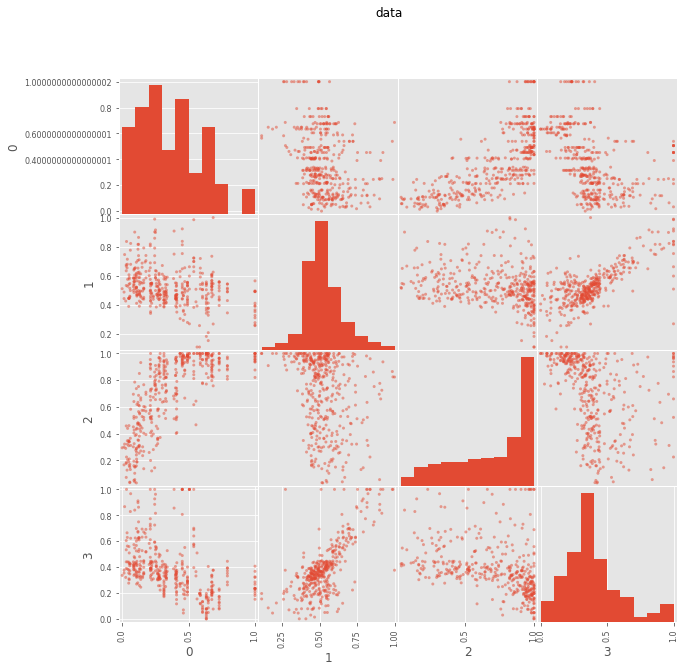


STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Time elapsed: 2.43

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.50

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.37

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.34

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.34

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.35

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimizat

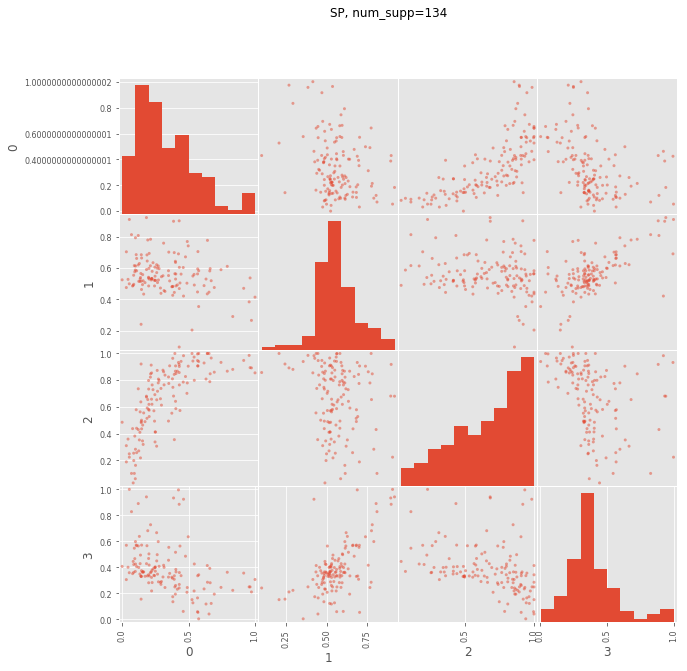



---------------------------
Running for num_supp=134, alpha=100000
Exp(2 * U / alpha) = Exp(2 * 0.0595 / 100000.00) = Exp(0.00000119)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0595 / 100000.000) = Exp(0.00000119)

Running chain. Length=15000, Burn=5000, Thin=1000
Difference factor: 840636.70

acceptance_rate=1.00000000, step_size=0.00100000
Energy diff: -0.00000033
acceptance_rate=0.23701731, step_size=0.00188744
Energy diff: -0.00000033
acceptance_rate=0.33577615, step_size=0.05983494
Energy diff: -0.00001845
acceptance_rate=0.23189693, step_size=0.01065785
Energy diff: -0.00000178
acceptance_rate=0.34255248, step_size=0.00189839
Energy diff: 0.00000004
acceptance_rate=0.37110104, step_size=0.02924847
Energy diff: -0.00000596
acceptance_rate=0.31126416, step_size=0.25000000
Energy diff: -0.00013316
acceptance_rate=0.27023424, step_size=0.01717987
Energy diff: -0.00000641
acceptance_rate=0.31094818, step_size=0.00204006
Energy diff: 0.00000034
acceptance_rate=0.

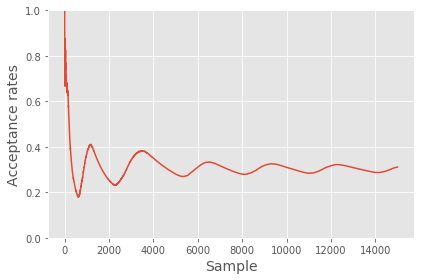

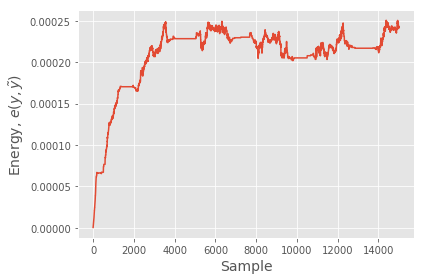

Acceptance rate: 0.311
percent steps that improved energy score: 0.146


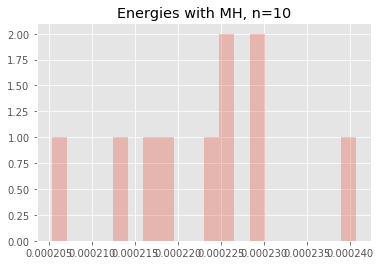

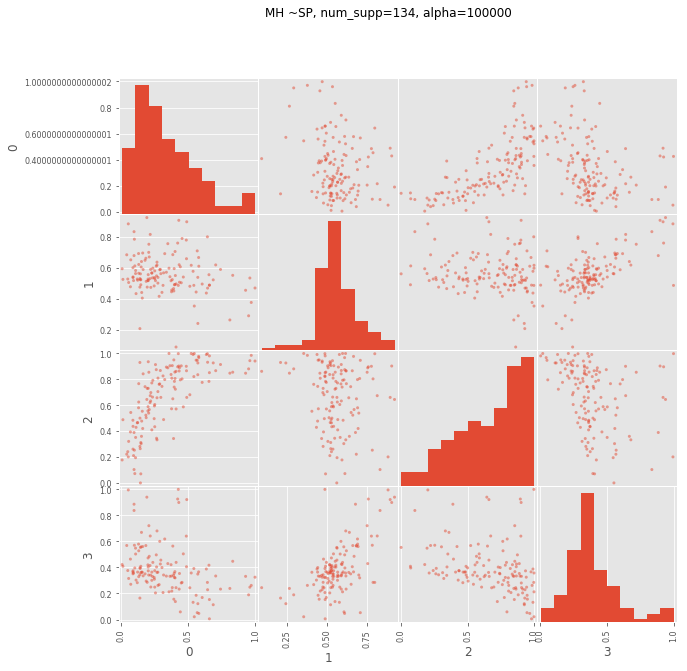



---------------------------
Running for num_supp=134, alpha=10000
Exp(2 * U / alpha) = Exp(2 * 0.0595 / 10000.00) = Exp(0.00001190)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0595 / 10000.000) = Exp(0.00001190)

Running chain. Length=15000, Burn=5000, Thin=1000
Difference factor: 84063.67

acceptance_rate=1.00000000, step_size=0.00100000
Energy diff: -0.00000060
acceptance_rate=0.36750999, step_size=0.25000000
Energy diff: -0.00017874
acceptance_rate=0.29247169, step_size=0.02147484
Energy diff: -0.00000235
acceptance_rate=0.34162594, step_size=0.22057551
Energy diff: -0.00003082
acceptance_rate=0.28823725, step_size=0.04194304
Energy diff: 0.00001503
acceptance_rate=0.31298320, step_size=0.19147180
Energy diff: -0.00005671
acceptance_rate=0.29615641, step_size=0.02684355
Energy diff: 0.00001928
acceptance_rate=0.30660827, step_size=0.25000000
Energy diff: -0.00010185
acceptance_rate=0.29895017, step_size=0.01717987
Energy diff: -0.00000672
acceptance_rate=0.3060

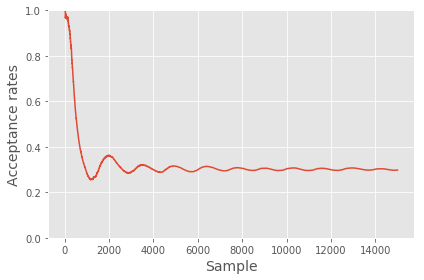

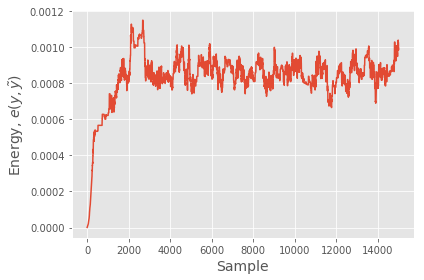

Acceptance rate: 0.298
percent steps that improved energy score: 0.141


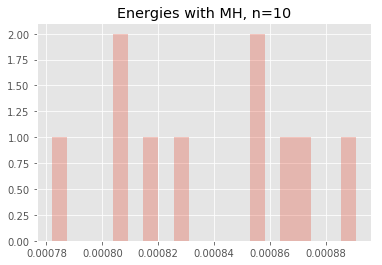

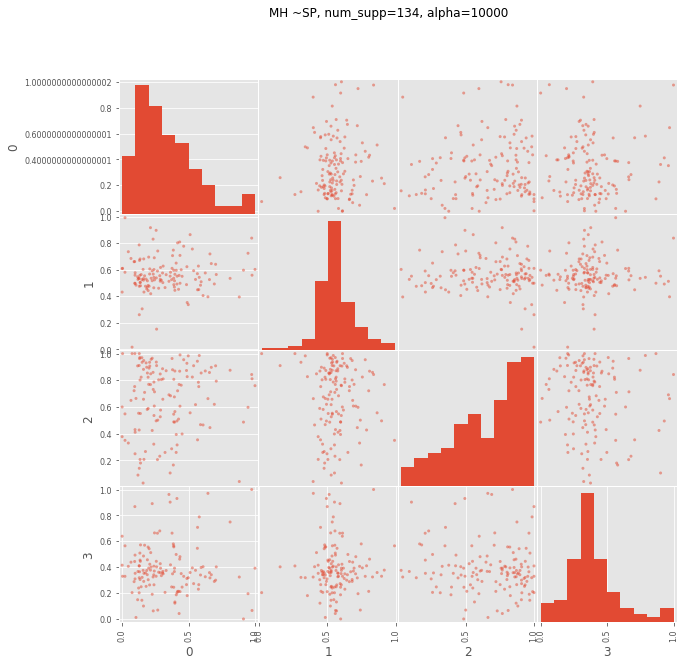



---------------------------
Running for num_supp=134, alpha=100
Exp(2 * U / alpha) = Exp(2 * 0.0595 / 100.00) = Exp(0.00118957)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0595 / 100.000) = Exp(0.00118957)

Running chain. Length=15000, Burn=5000, Thin=1000
Difference factor: 840.64

acceptance_rate=1.00000000, step_size=0.00100000
Energy diff: -0.00000032
acceptance_rate=0.84820240, step_size=0.25000000
Energy diff: 0.00117904
acceptance_rate=0.75749500, step_size=0.25000000
Energy diff: -0.00026665
acceptance_rate=0.71745891, step_size=0.25000000
Energy diff: -0.00073762
acceptance_rate=0.69976674, step_size=0.25000000
Energy diff: 0.00081226
acceptance_rate=0.69634764, step_size=0.25000000
Energy diff: 0.00051439
acceptance_rate=0.68562542, step_size=0.25000000
Energy diff: -0.00010121
acceptance_rate=0.67758522, step_size=0.25000000
Energy diff: -0.00124691
acceptance_rate=0.67605399, step_size=0.25000000
Energy diff: -0.00020920
acceptance_rate=0.66790105, ste

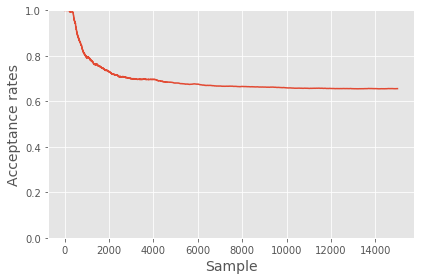

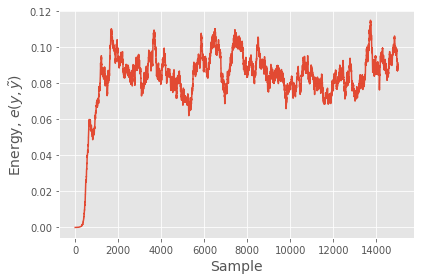

Acceptance rate: 0.656
percent steps that improved energy score: 0.316


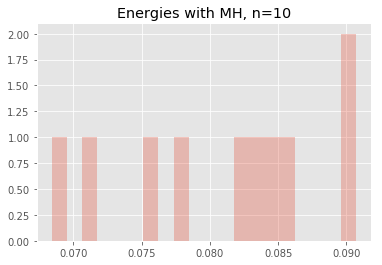

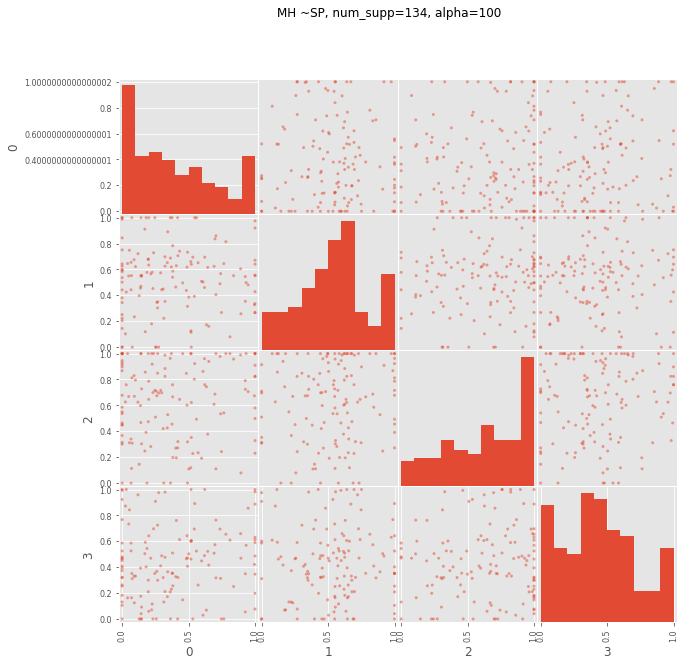


STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 4.25

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 4.47

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 4.39

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 4.54

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 4.77

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 4.64

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 4.33

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow

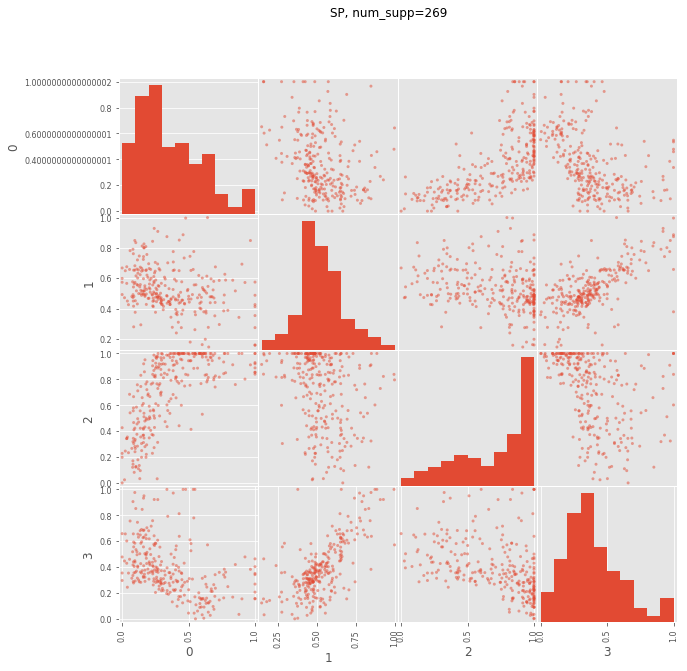



---------------------------
Running for num_supp=269, alpha=100000
Exp(2 * U / alpha) = Exp(2 * 0.0297 / 100000.00) = Exp(0.00000059)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0297 / 100000.000) = Exp(0.00000059)

Running chain. Length=15000, Burn=5000, Thin=1000
Difference factor: 1684380.82

acceptance_rate=1.00000000, step_size=0.00100000
Energy diff: -0.00000005
acceptance_rate=0.19573901, step_size=0.07247757
Energy diff: -0.00000709
acceptance_rate=0.39906729, step_size=0.00443222
Energy diff: -0.00000047
acceptance_rate=0.30564194, step_size=0.25000000
Energy diff: -0.00001609
acceptance_rate=0.25824725, step_size=0.01099512
Energy diff: -0.00000268
acceptance_rate=0.33751000, step_size=0.00991470
Energy diff: -0.00000008
acceptance_rate=0.31259720, step_size=0.15275604
Energy diff: -0.00001303
acceptance_rate=0.27556656, step_size=0.02147484
Energy diff: -0.00000208
acceptance_rate=0.31728045, step_size=0.00573768
Energy diff: -0.00000023
acceptance_rate

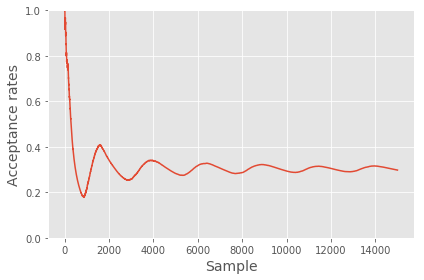

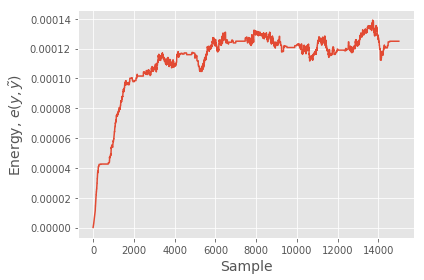

Acceptance rate: 0.298
percent steps that improved energy score: 0.136


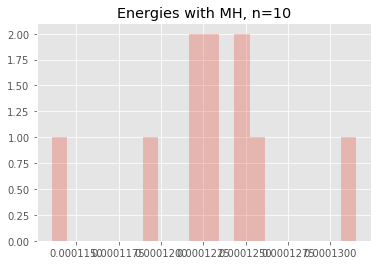

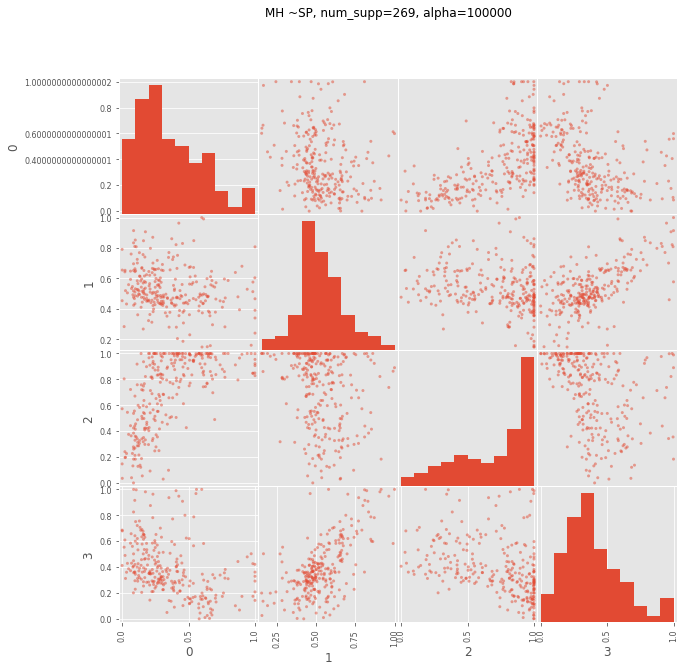



---------------------------
Running for num_supp=269, alpha=10000
Exp(2 * U / alpha) = Exp(2 * 0.0297 / 10000.00) = Exp(0.00000594)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0297 / 10000.000) = Exp(0.00000594)

Running chain. Length=15000, Burn=5000, Thin=1000
Difference factor: 168438.08

acceptance_rate=1.00000000, step_size=0.00100000
Energy diff: -0.00000006
acceptance_rate=0.47536618, step_size=0.25000000
Energy diff: -0.00003389
acceptance_rate=0.30179880, step_size=0.25000000
Energy diff: -0.00003038
acceptance_rate=0.32518880, step_size=0.18786187
Energy diff: -0.00001870
acceptance_rate=0.30423192, step_size=0.14155776
Energy diff: 0.00001008
acceptance_rate=0.30658491, step_size=0.12764787
Energy diff: -0.00003008
acceptance_rate=0.30837592, step_size=0.10871636
Energy diff: 0.00000123
acceptance_rate=0.29613407, step_size=0.06553600
Energy diff: -0.00000950
acceptance_rate=0.29895017, step_size=0.20000000
Energy diff: -0.00002839
acceptance_rate=0.307

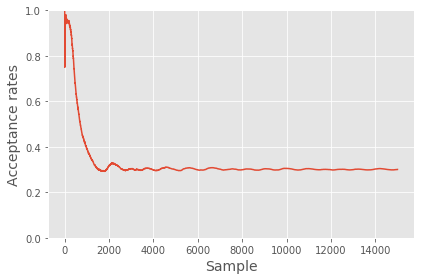

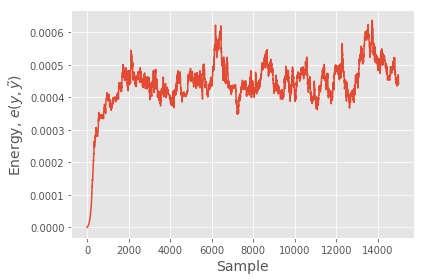

Acceptance rate: 0.301
percent steps that improved energy score: 0.141


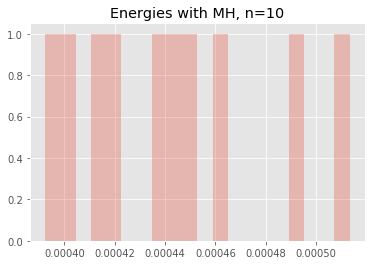

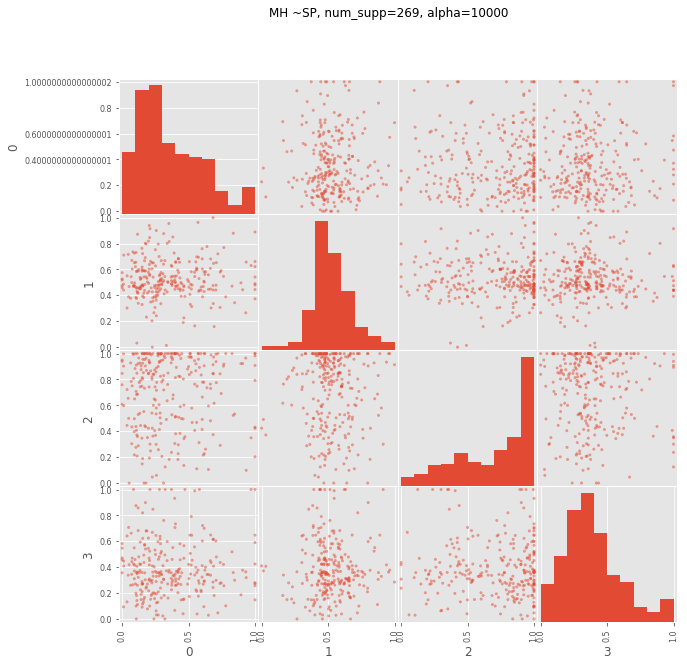



---------------------------
Running for num_supp=269, alpha=100
Exp(2 * U / alpha) = Exp(2 * 0.0297 / 100.00) = Exp(0.00059369)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0297 / 100.000) = Exp(0.00059369)

Running chain. Length=15000, Burn=5000, Thin=1000
Difference factor: 1684.38

acceptance_rate=1.00000000, step_size=0.00100000
Energy diff: -0.00000002
acceptance_rate=0.88149134, step_size=0.25000000
Energy diff: 0.00004976
acceptance_rate=0.78481013, step_size=0.25000000
Energy diff: -0.00129409
acceptance_rate=0.75344291, step_size=0.25000000
Energy diff: -0.00010893
acceptance_rate=0.73808730, step_size=0.25000000
Energy diff: -0.00021874
acceptance_rate=0.73287123, step_size=0.25000000
Energy diff: -0.00041640
acceptance_rate=0.72450567, step_size=0.25000000
Energy diff: -0.00075080
acceptance_rate=0.72081508, step_size=0.25000000
Energy diff: 0.00011078
acceptance_rate=0.71471421, step_size=0.25000000
Energy diff: -0.00049445
acceptance_rate=0.71278329, s

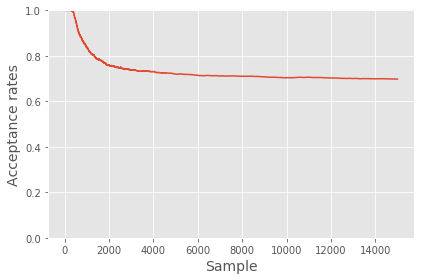

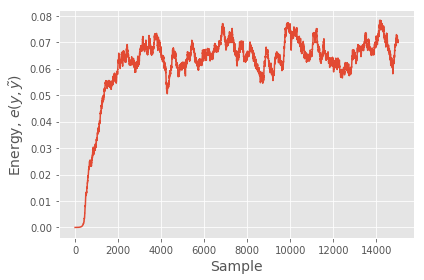

Acceptance rate: 0.698
percent steps that improved energy score: 0.332


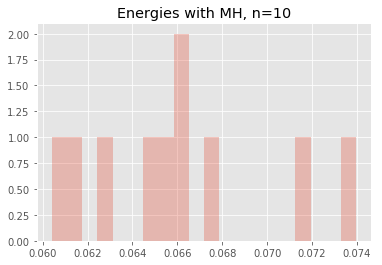

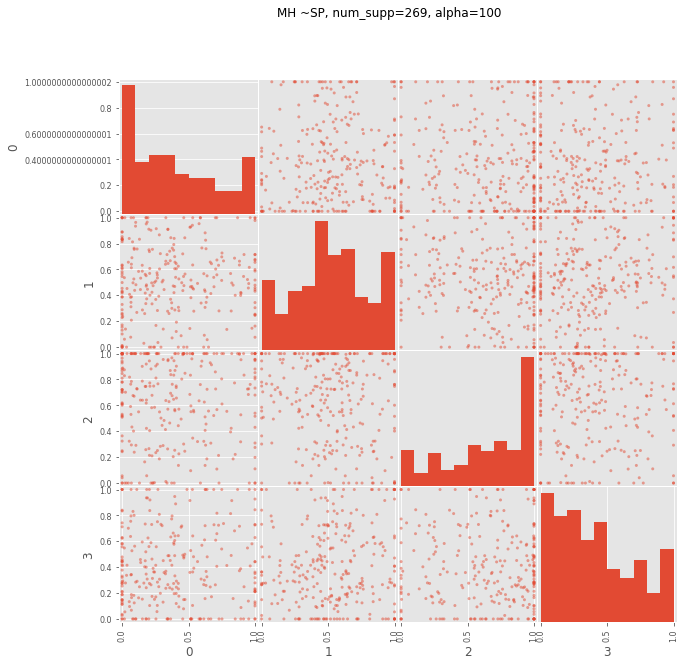


STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 6.22

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 6.11

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 6.11

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 6.33

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 6.14

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 6.20

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 6.16

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow

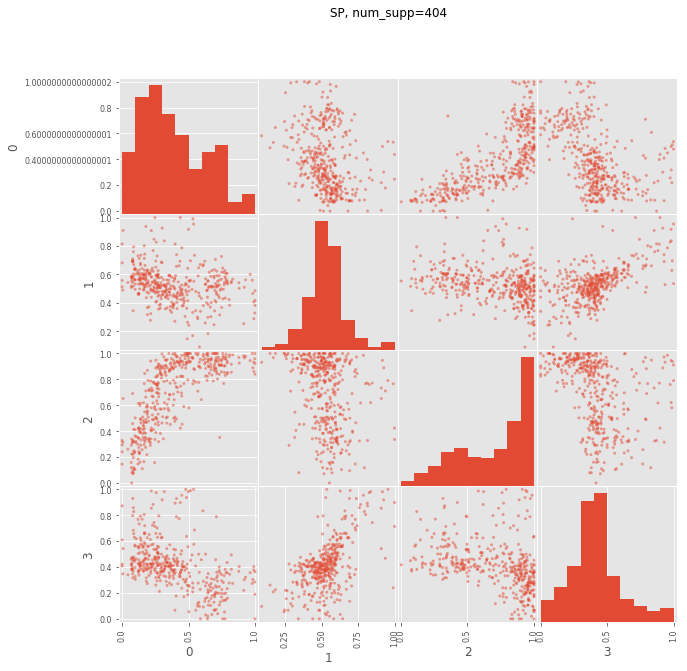



---------------------------
Running for num_supp=404, alpha=100000
Exp(2 * U / alpha) = Exp(2 * 0.0198 / 100000.00) = Exp(0.00000040)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0198 / 100000.000) = Exp(0.00000040)

Running chain. Length=15000, Burn=5000, Thin=1000
Difference factor: 2528128.87

acceptance_rate=1.00000000, step_size=0.00100000
Energy diff: -0.00000003
acceptance_rate=0.22237017, step_size=0.10240000
Energy diff: -0.00000552
acceptance_rate=0.36842105, step_size=0.00667953
Energy diff: -0.00000019
acceptance_rate=0.35228787, step_size=0.10291171
Energy diff: -0.00000446
acceptance_rate=0.27057647, step_size=0.05242880
Energy diff: -0.00000097
acceptance_rate=0.31698214, step_size=0.00622578
Energy diff: 0.00000027
acceptance_rate=0.32770495, step_size=0.09592067
Energy diff: -0.00000393
acceptance_rate=0.28470767, step_size=0.06553600
Energy diff: -0.00000066
acceptance_rate=0.30944843, step_size=0.00778222
Energy diff: -0.00000009
acceptance_rate=

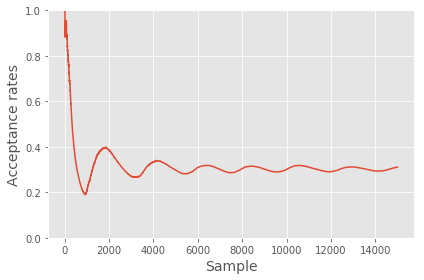

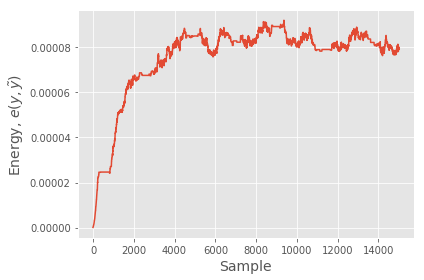

Acceptance rate: 0.311
percent steps that improved energy score: 0.146


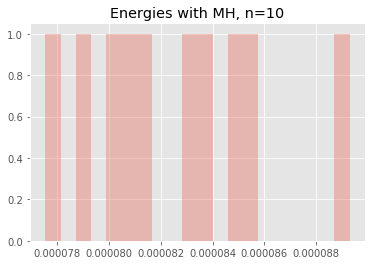

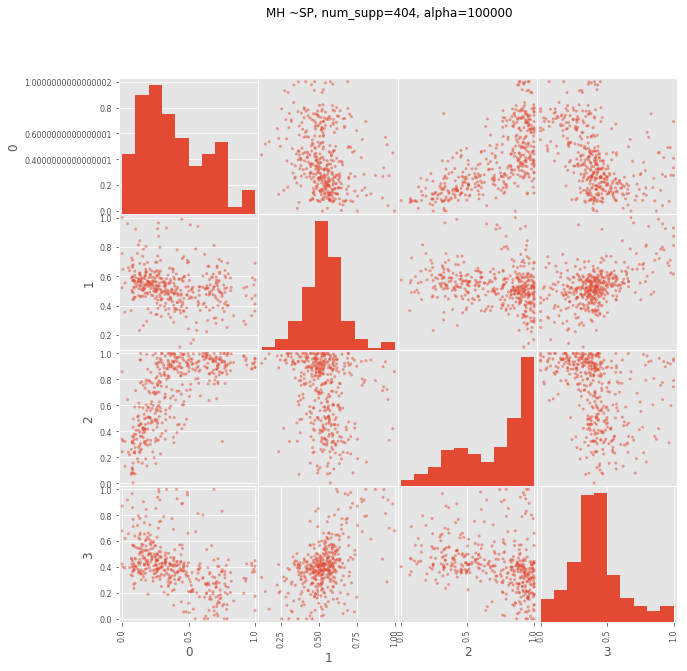



---------------------------
Running for num_supp=404, alpha=10000
Exp(2 * U / alpha) = Exp(2 * 0.0198 / 10000.00) = Exp(0.00000396)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0198 / 10000.000) = Exp(0.00000396)

Running chain. Length=15000, Burn=5000, Thin=1000
Difference factor: 252812.89

acceptance_rate=1.00000000, step_size=0.00100000
Energy diff: -0.00000007
acceptance_rate=0.48735020, step_size=0.25000000
Energy diff: -0.00002857
acceptance_rate=0.31978681, step_size=0.25000000
Energy diff: -0.00001133
acceptance_rate=0.31186139, step_size=0.16307454
Energy diff: -0.00000647
acceptance_rate=0.31022992, step_size=0.19568945
Energy diff: -0.00000233
acceptance_rate=0.30685151, step_size=0.07549747
Energy diff: -0.00000902
acceptance_rate=0.29704510, step_size=0.16000000
Energy diff: -0.00001508
acceptance_rate=0.29689583, step_size=0.20000000
Energy diff: -0.00001263


In [ ]:
# Run experiments and print results.
if run_boston:
    #np.random.seed(123)
    results = run_experiments(dataset_name, data, num_supp, alphas,
                              max_iter, lr, num_sp_samples, burnin=burnin,
                              num_cv_splits=num_cv_splits)
    
    global_results.extend(results)

In [ ]:
if run_boston:
    plot_final_results(results, 'boston', alphas)

## DIABETES

In [ ]:
# Get diabetes data.
dataset_name = 'diabetes'
dataset = load_diabetes()
d = pd.DataFrame(dataset.data)
d.columns = dataset.feature_names
d['TARGET'] = dataset.target

data = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
data = scale_01(data)
np.random.shuffle(data)

# Optional subsetting for troubleshooting.
#data = data[np.random.choice(len(data), 100, replace=False)]
#data = data[:, [1, 2, 3]]
#plot_nd(data, title='Data, scaled [0, 1]')

In [ ]:
# Define set of parameters to test.
train_size = int(len(data) * (num_cv_splits - 1) / num_cv_splits) 
num_supp = [int(train_size * i / 3.) for i in [1, 2, 3]]
max_iter = 301
lr = 0.5
burnin = 20000

In [ ]:
# Run experiments and print results.
if run_diabetes:
    #np.random.seed(123)
    results = run_experiments(dataset_name, data, num_supp, alphas,
                              max_iter, lr, num_sp_samples,
                              num_cv_splits=num_cv_splits)
    
    global_results.extend(results)

In [ ]:
if run_diabetes:
    plot_final_results(results, 'diabetes', alphas)

## CALIFORNIA

In [ ]:
# Get diabetes data.
dataset_name = 'california'
dataset = fetch_california_housing()
d = pd.DataFrame(dataset.data)
d.columns = dataset.feature_names
d['TARGET'] = dataset.target

data = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
data = scale_01(data)
np.random.shuffle(data)

# Optional subsetting for troubleshooting.
#data = data[np.random.choice(len(data), 100, replace=False)]
#data = data[:, [1, 2, 3]]
#plot_nd(data, title='Data, scaled [0, 1]')

In [ ]:
# Define set of parameters to test.
train_size = int(len(data) * (num_cv_splits - 1) / num_cv_splits) 
num_supp = [int(train_size * i / 3.) for i in [1, 2, 3]]
max_iter = 501
lr = 1.
burnin = 20000

In [ ]:
# Run experiments and print results.
if run_california:
    #np.random.seed(123)
    results = run_experiments(dataset_name, data, num_supp, alphas,
                              max_iter, lr, num_sp_samples,
                              num_cv_splits=num_cv_splits)

    global_results.extend(results)

In [ ]:
if run_california:
    plot_final_results(results, 'california', alphas)

___

# Save and plot global results

In [ ]:
# Write results to file.
import json
gr_as_dict = [row._asdict() for row in global_results]
with open('../output/regression_global_results.json', 'w') as outfile:
    json.dump(gr_as_dict, outfile)

___